In [1]:
# package
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# SlotArm : 코인이 나올 확률을 통해 보상 점수를 반환
class SlotArm():
    def __init__(self, p):
        self.p = p # 코인 나올 확률

    def draw(self):
        if self.p > random.random():
            return 1.0
        else:
            return 0.0

In [8]:
test_arms = SlotArm(0.3)
print(f'Result : {test_arms.draw()}')

Result : 0.0


In [26]:
# ε-greedy : 확률 ε에 따라 랜덤한 행동 선택(탐색), 1-ε 확률로 초기 보상이 최대가 되는 행동 선택(이용)
class EplsilonGreedy():
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def initialize(self, n_arms):
        self.n = np.zeros(n_arms) # 시행 횟수 초기화
        self.v = np.zeros(n_arms) # 평균 보상 가치 초기화

    # 선택 정책
    def select_arm(self):
        if self.epsilon > random.random():
            return np.random.randint(0, len(self.v)) # 랜덤으로 arm 선택(탐색)
        else:
            return np.argmax(self.v) # 높은 가치의 arm 선택(이용)

    # 파라미터 갱신
    def update(self, chosen_arm, reward, t):
        self.n[chosen_arm] += 1 # 선택한 팔 시행 횟수 update
        
        #선택한 팔 가치 update
        n = self.n[chosen_arm]
        v = self.v[chosen_arm]
        self.v[chosen_arm] = ((n-1) / float(n)) * v  + (1 / float(n)) * reward

    def label(self):
        return 'ε-greedy'

In [27]:
# UCB1 : 성공률 + 바이어스를 최대로 만드는 행동을 선택하는 방법 (바이어스 : 우연에 의한 성공률 분포 크기)
class UCB1():
    def initialize(self, n_arms):
        self.n = np.zeros(n_arms) # 시행 횟수 초기화
        self.w = np.zeros(n_arms) # 성공 횟수 초기화
        self.v = np.zeros(n_arms) # 평균 보상 가치 초기화

    def select_arm(self):
        for i in range(len(self.n)):
            if self.n[i] == 0: 
                return i # 시행 횟수 0인 경우 i를 반환 
        
        return np.argmax(self.v) # 시행 횟수가 1 이상인 경우 가치가 높은 arm 선택
    
    def update(self, chosen_arm, reward, t):
        self.n[chosen_arm] += 1 # 시행 횟수 update

        if reward == 1.0:
            self.w[chosen_arm] += 1 # 성공 시 w update

        for i in range(len(self.n)):
            if self.n[i] == 0:
                return # 시행 횟수 0 인 경우 가치 갱신 X
        
        for i in range(len(self.v)):
            self.v[i] = self.w[i] / self.n[i] + (2 * math.log(t) / self.n[i]) ** 0.

    def label(self):
        return 'ucb1'


In [28]:
# 시뮬레이션
def play(algo, arms, num_sims, num_time):
    times = np.zeros(num_sims * num_time) # 현재 시행 횟수
    rewards = np.zeros(num_sims * num_time) # 보상

    # 시뮬레이션 횟수
    for sim in range(num_sims):
        algo.initialize(len(arms))

        # 게임 횟수
        for time in range(num_time):
            index = sim * num_time + time

            times[index] = time + 1
            chosen_arm = algo.select_arm()
            reward = arms[chosen_arm].draw()
            rewards[index] = reward

            # Update
            algo.update(chosen_arm, reward, times[index])
    
    return [times, rewards]

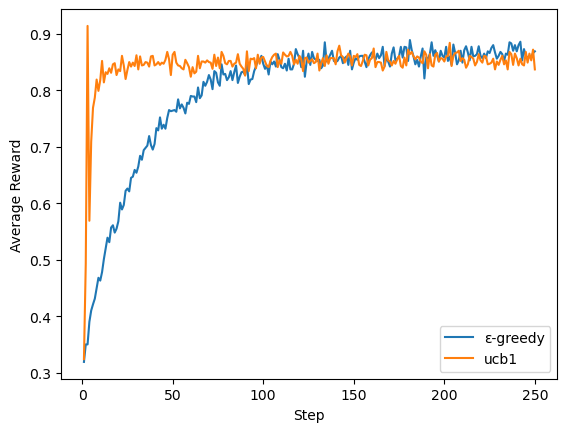

In [36]:
# 시뮬레이션 및 보상 출력
arms = (SlotArm(0.3), SlotArm(0.5), SlotArm(0.9))
algos = (EplsilonGreedy(0.1), UCB1())
mean_rewards = {}

for algo in algos:
    results = play(algo, arms, 1000, 250) # 250번씩 1000번 시뮬레이션

    df = pd.DataFrame({'times': results[0], 'rewards': results[1]})
    mean_rewards[algo.label()] = df['rewards'].groupby(df['times']).mean()
    plt.plot(mean_rewards[algo.label()], label=algo.label())

plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.legend(loc='best')
plt.show()

In [38]:
# best reward 출력
best = {}

for algo_label, rewards in mean_rewards.items():
    max_reward = rewards.max()
    max_time = rewards.idxmax()

    best[algo_label] = {'time': max_time, 'reward': max_reward}

print(best)

{'ε-greedy': {'time': 181.0, 'reward': 0.889}, 'ucb1': {'time': 3.0, 'reward': 0.914}}
